In [187]:
import numpy as np
import astropy.io.fits as fits
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.constants import c as c_const
from scipy.integrate import quad
from IPython.display import Image


In [223]:

"""
    All the three SDSS_MS, GAMA_Ms, and GAMA_ALL are from "SpecObjv27", with QN>2
    SDSS doesnt have G23 => MS & equatorial will be the same for it.
    link: 'http://www.gama-survey.org/dr4/schema/dmu.php?id=91'

"""

#PC
#SpecObjv27_raw = fits.open('/home/safiye/safiye/data1/GAMA/SpecCat/SpecObjv27.fits')[1].data

#laptop SpecObjv27
SpecObjv27_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/SpecCat/SpecObjv27.fits')[1].data
print('SpecObjv27_raw file is opened')


# Apply selection criteria : "SpecObjv27"
SpecObjv27 =  (SpecObjv27_raw['NQ'] > 2) & (SpecObjv27_raw['Z'] > 0)

num_of_SpecObj = SpecObjv27.sum()
print('number of the objects in "SpecObjv27" with NQ > 2: ', num_of_SpecObj)


SpecObjv27_raw file is opened
number of the objects in "SpecObjv27" with NQ > 2:  318687


In [224]:
# Create masks for each survey
SDSS_mask = (SpecObjv27_raw['SURVEY_CODE'] == 1) & SpecObjv27
GAMA_mask = (SpecObjv27_raw['SURVEY_CODE'] == 5) & SpecObjv27

SDSS = SpecObjv27_raw[SDSS_mask]
GAMA = SpecObjv27_raw[GAMA_mask]

print(f"Number of objects from SDSS (QN>2): {len(SDSS)}")
print(f"Number of objects from GAMA (QN>2): {len(GAMA)}")


Number of objects from SDSS (QN>2): 53154
Number of objects from GAMA (QN>2): 244363


In [218]:
# Define region limits
regions_SpecObj = {
    'G02': {'RA': (30.20, 38.80), 'DEC': (-10.25, -3.72)},
    'G09': {'RA': (129.0, 141.0), 'DEC': (-2.0, 3.0)},
    'G12': {'RA': (174.0, 176.0), 'DEC': (-3.0, 2.0)},
    'G15': {'RA': (211.5, 223.5), 'DEC': (-2.0, 3.0)},
    'G23': {'RA': (339.0, 351.0), 'DEC': (-35.0, -30.0)},
}

# masks for each region in SpecObjv27
region_masks_SpecObj = {}
for region, limits in regions_SpecObj.items():
    ra_mask_SpecObj = (SpecObjv27_raw['RA'] >= limits['RA'][0]) & (SpecObjv27_raw['RA'] <= limits['RA'][1])
    dec_mask_SpecObj = (SpecObjv27_raw['DEC'] >= limits['DEC'][0]) & (SpecObjv27_raw['DEC'] <= limits['DEC'][1])
    combined_mask_SpecObj = ra_mask_SpecObj & dec_mask_SpecObj & SpecObjv27
    region_masks_SpecObj[region] = combined_mask_SpecObj

    # the number of objects meeting the criteria (NQ>2) in each region
    print(f'Number of objects in SpecObjv27 {region}: {combined_mask_SpecObj.sum()}')

    # RA values of the objects that Are in the regions
    RA_values = SpecObjv27_raw['RA'][combined_mask_SpecObj]
    print(f"check RA values in {region}: {RA_values}")

# the total number of objects in All regions
total_objects_in_all_regions_SpecObj = sum(mask.sum() for mask in region_masks_SpecObj.values())
print("Total number of objects of 'SpecObjv27' in all regions:", total_objects_in_all_regions_SpecObj)

Number of objects in SpecObjv27 G02: 34088
check RA values in G02: [34.18279 34.18972 34.56214 ... 33.93708 35.10279 36.89401]
Number of objects in SpecObjv27 G09: 69732
check RA values in G09: [129.083   129.106   129.01621 ... 139.11525 132.43846 133.11586]
Number of objects in SpecObjv27 G12: 11604
check RA values in G12: [174.006   174.02167 174.09204 ... 175.85462 175.95199 175.52913]
Number of objects in SpecObjv27 G15: 72737
check RA values in G15: [211.54012 211.56321 211.52367 ... 219.63961 223.04867 220.25224]
Number of objects in SpecObjv27 G23: 46837
check RA values in G23: [344.15317 347.465   347.84533 ... 347.28883 340.44713 342.24433]
Total number of objects of 'SpecObjv27' in all regions: 234998


Number of objects in SpecObjv27 G02: 34088
RA_min:  30.2
RA_max:  38.8


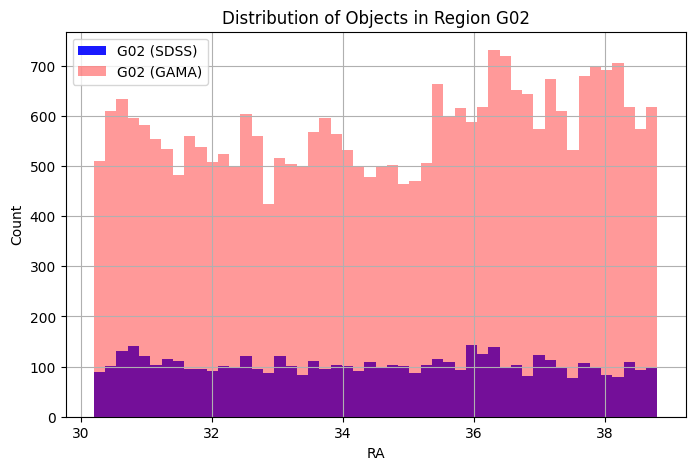

Number of objects in SpecObjv27 G09: 69732
RA_min:  129.0
RA_max:  141.0


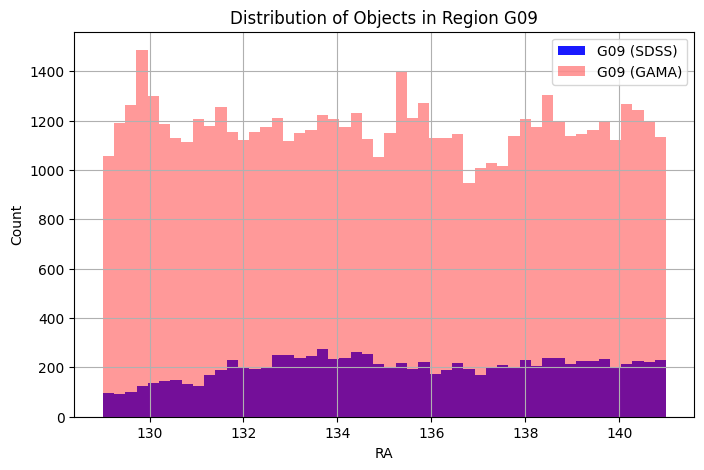

Number of objects in SpecObjv27 G12: 11604
RA_min:  174.0
RA_max:  176.0


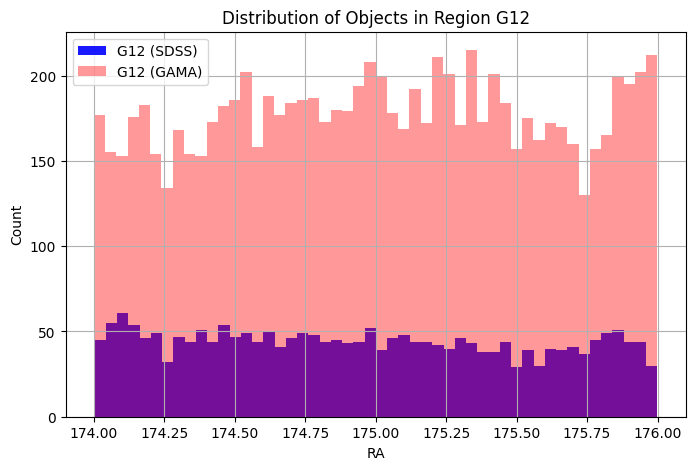

Number of objects in SpecObjv27 G15: 72737
RA_min:  211.5
RA_max:  223.5


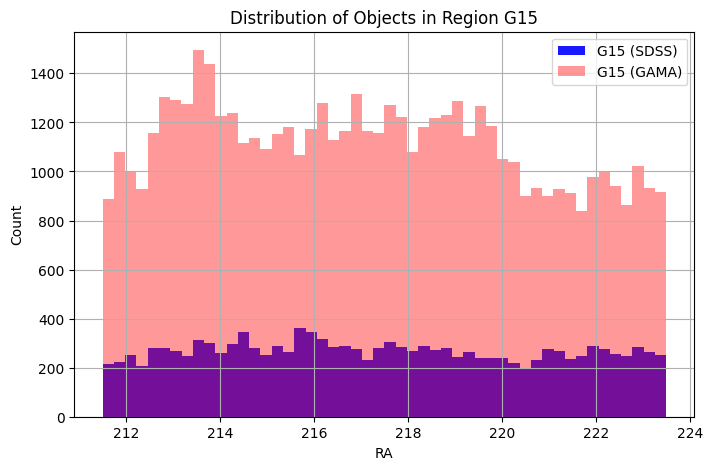

Number of objects in SpecObjv27 G23: 46837
RA_min:  339.0
RA_max:  351.0


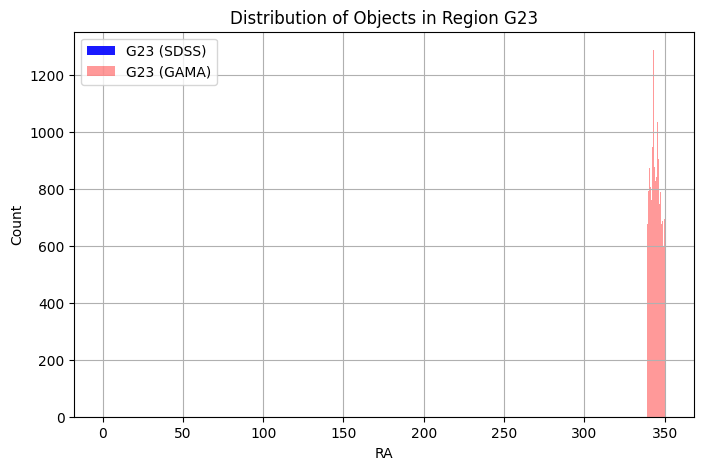

In [219]:
# histograms of the number of objects for each region

for region, limits in regions_SpecObj.items():
    num_objects = region_masks_SpecObj[region].sum()
    print(f'Number of objects in SpecObjv27 {region}: {num_objects}')

    # Get objects from SDSS and GAMA
    sdss_objects = region_masks_SpecObj[region] & SDSS_mask
    gama_objects = region_masks_SpecObj[region] & GAMA_mask

    RA_min = limits['RA'][0]
    print('RA_min: ', RA_min)
    RA_max = limits['RA'][1]
    print('RA_max: ', RA_max)

    # histogram of the regions based on their RA
    plt.figure(figsize=(8, 5))
    plt.hist(SpecObjv27_raw['RA'][sdss_objects], bins=50, color='blue', alpha=0.9, label=f'{region} (SDSS)')
    plt.hist(SpecObjv27_raw['RA'][gama_objects], bins=50, color='red', alpha=0.4, label=f'{region} (GAMA)')
    plt.title(f'Distribution of Objects in Region {region}')
    plt.xlabel('RA')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()


Number of objects in SpecObjv27 G23: 46837
RA_min:  339.0
RA_max:  351.0


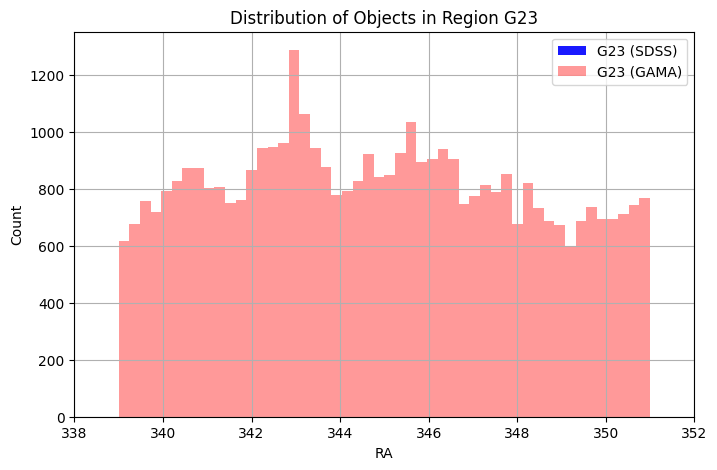

In [220]:
# Create a separate plot for region G23
G23_hist = 'G23'  # Use a different variable name to not get mistaken
limits = regions_SpecObj[G23_hist]
num_objects = region_masks_SpecObj[G23_hist].sum()
print(f'Number of objects in SpecObjv27 {G23_hist}: {num_objects}')

sdss_objects = region_masks_SpecObj[G23_hist] & SDSS_mask
gama_objects = region_masks_SpecObj[G23_hist] & GAMA_mask

RA_min = limits['RA'][0]  # Start one interval before
print('RA_min: ', RA_min)
RA_max = limits['RA'][1]  # End one interval after
print('RA_max: ', RA_max)

# Plot a histogram for region G23 based on their RA
plt.figure(figsize=(8, 5))
plt.hist(SpecObjv27_raw['RA'][sdss_objects], bins=50, color='blue', alpha=0.9, label=f'{G23_hist} (SDSS)')
plt.hist(SpecObjv27_raw['RA'][gama_objects], bins=50, color='red', alpha=0.4, label=f'{G23_hist} (GAMA)')
plt.title(f'Distribution of Objects in Region {G23_hist}')
plt.xlabel('RA')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
x_min = 338.0
x_max = 352.0
plt.xlim(x_min, x_max)
plt.show()

In [221]:
# Determine the number of objects in each region from SDSS and GAMA surveys
SDSS_counts = {}
GAMA_counts = {}

for region, mask in region_masks_SpecObj.items():
    SDSS_counts[region] = (mask & SDSS_mask).sum()
    GAMA_counts[region] = (mask & GAMA_mask).sum()

    # Print the number of objects from each survey in each region
    print(f"Number of SDSS (NQ>2) objects in {region}: {SDSS_counts[region]}")
    print(f"Number of GAMA (NQ>2) objects in {region}: {GAMA_counts[region]}")


Number of SDSS (NQ>2) objects in G02: 5203
Number of GAMA (NQ>2) objects in G02: 28703
Number of SDSS (NQ>2) objects in G09: 10024
Number of GAMA (NQ>2) objects in G09: 58690
Number of SDSS (NQ>2) objects in G12: 2214
Number of GAMA (NQ>2) objects in G12: 8887
Number of SDSS (NQ>2) objects in G15: 13414
Number of GAMA (NQ>2) objects in G15: 55686
Number of SDSS (NQ>2) objects in G23: 0
Number of GAMA (NQ>2) objects in G23: 41011


In [194]:
# Main Survey regions : G09, G12, G15, G23
MS_mask = (
        region_masks_SpecObj['G09'] |
        region_masks_SpecObj['G12'] |
        region_masks_SpecObj['G15'] |
        region_masks_SpecObj['G23']
)
# equatorial regions: G09, G12, G15
equatorial_mask = (
        region_masks_SpecObj['G09'] |
        region_masks_SpecObj['G12'] |
        region_masks_SpecObj['G15']
)


# Create a dictionary to store all subsets
master_basket = {}

# Create the 'baskets' dictionary to hold individual subsets
baskets = {}

# GAMA survey subsets
baskets['GAMA_ALL'] = SpecObjv27_raw[GAMA_mask & SpecObjv27]
baskets['GAMA_MS'] = SpecObjv27_raw[GAMA_mask & MS_mask & SpecObjv27]
baskets['GAMA_equatorial'] = SpecObjv27_raw[GAMA_mask & equatorial_mask & SpecObjv27]

# SDSS survey subsets
baskets['SDSS_ALL'] = SpecObjv27_raw[SDSS_mask & SpecObjv27]
baskets['SDSS_MS'] = SpecObjv27_raw[SDSS_mask & MS_mask & SpecObjv27]

# Add the 'baskets' dictionary to the 'master_basket' dictionary
master_basket['baskets'] = baskets
all_subsets = master_basket['baskets']

# Create a set to store unique CATAID values
unique_cataids = set()

# Create counters to track object counts
total_objects = 0
total_cataids = 0

# Iterate through all subsets
for subset in all_subsets.values():
    # Update the set of unique CATAID values
    unique_cataids.update(subset['CATAID'])
    # Update the total number of objects using the length of the subset
    total_objects += len(subset)

# Calculate the total number of unique CATAID values
total_cataids = len(unique_cataids)

# Print the number of objects in each basket
print(f"Number of objects in GAMA_ALL: {len(baskets['GAMA_ALL'])}")
print(f"Number of objects in GAMA_MS: {len(baskets['GAMA_MS'])}")
print(f"Number of objects in GAMA_equatorial: {len(baskets['GAMA_equatorial'])}")
print(f"Number of objects in SDSS_ALL: {len(baskets['SDSS_ALL'])}")
print(f"Number of objects in SDSS_MS (same as SDSS_equatorial): {len(baskets['SDSS_MS'])}")
print(f"Total number of unique objects in all subsets: {total_cataids}")
print(f"Total number of objects in all subsets: {total_objects}")


Number of objects in GAMA_ALL: 248682
Number of objects in GAMA_MS: 167940
Number of objects in GAMA_equatorial: 124535
Number of objects in SDSS_ALL: 57625
Number of objects in SDSS_MS (same as SDSS_equatorial): 27910
Total number of unique objects in all subsets: 306307
Total number of objects in all subsets: 626692


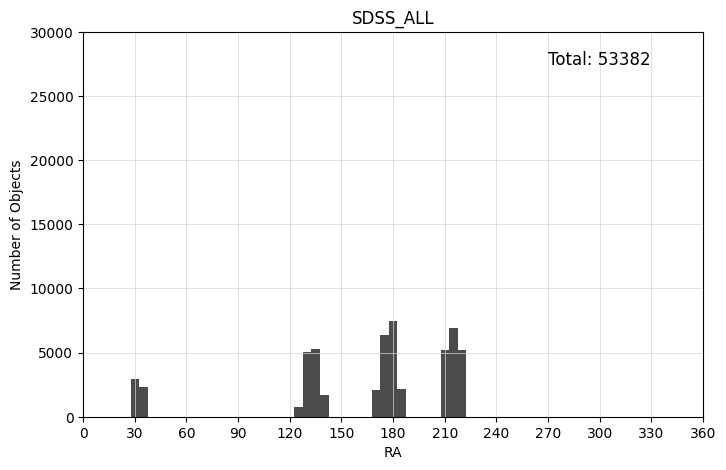

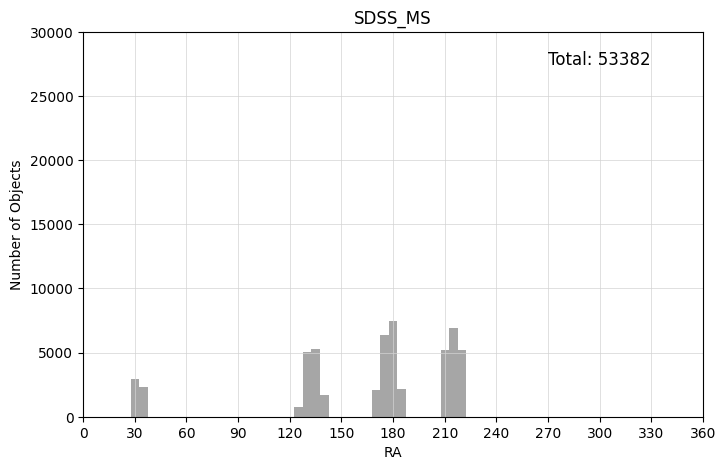

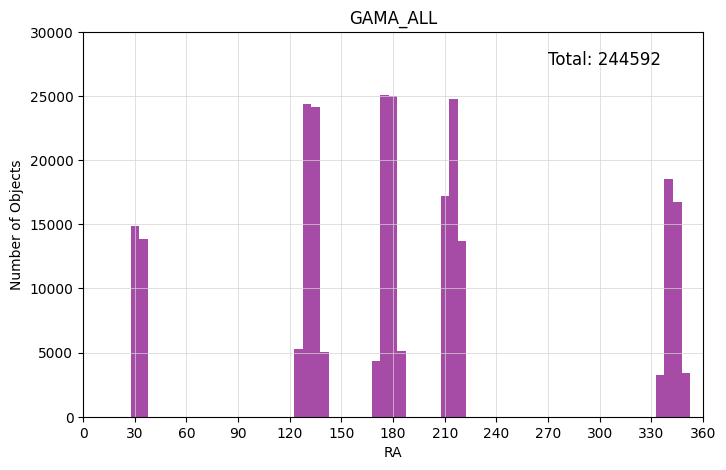

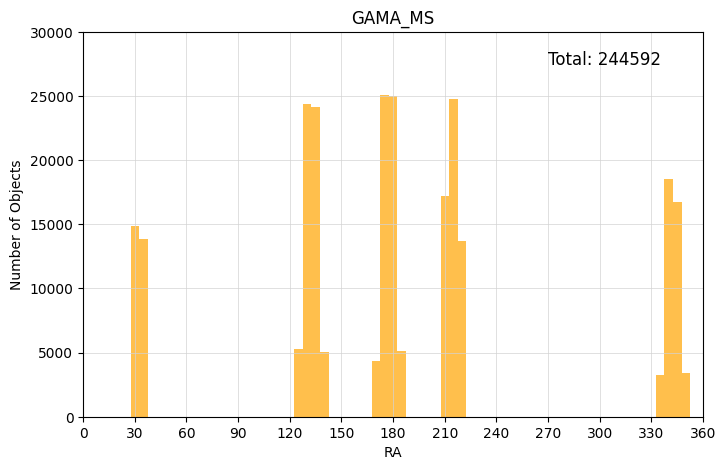

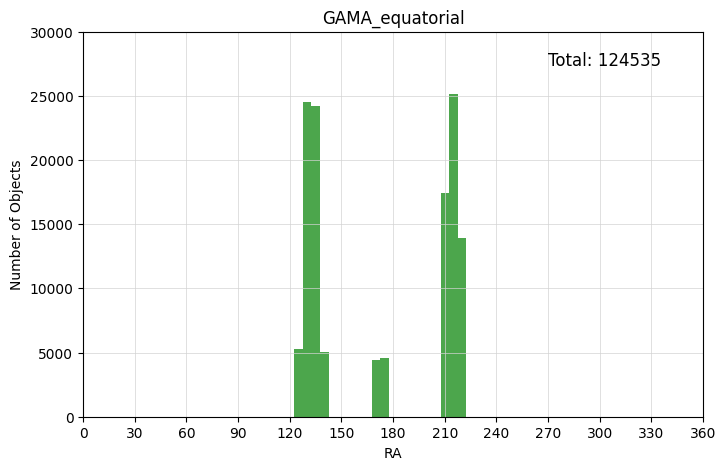

In [195]:
# Histograms for different surveys (ALL, MS, equatorial)
def plot_histogram(data, title, color):
    plt.figure(figsize=(8, 5))
    
    # bins for the x-axis from 0 to 360 with intervals of 5
    bins = np.arange(0, 361, 5)
    
    # Calculate histogram values
    hist, edges = np.histogram(data, bins=bins)

    # Plot the histogram using plt.bar() instead of plt.plot()
    plt.bar(bins[:-1], hist, width=5, color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel('RA')
    plt.ylabel('Number of Objects')
    plt.text(0.75, 0.95, f'Total: {len(data)}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    # Set limitations for all the plots
    plt.xlim(0, 360)
    plt.ylim(0, 30000)
    plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
    plt.xticks(range(0, 361, 30))

    plt.show()

plot_histogram(SDSS_ALL['RA'],'SDSS_ALL','black' )
plot_histogram(SDSS_MS['RA'], 'SDSS_MS', 'gray')
plot_histogram(GAMA_ALL['RA'], 'GAMA_ALL', 'purple')
plot_histogram(GAMA_MS['RA'], 'GAMA_MS', 'orange')
plot_histogram(GAMA_equatorial['RA'], 'GAMA_equatorial', 'green')


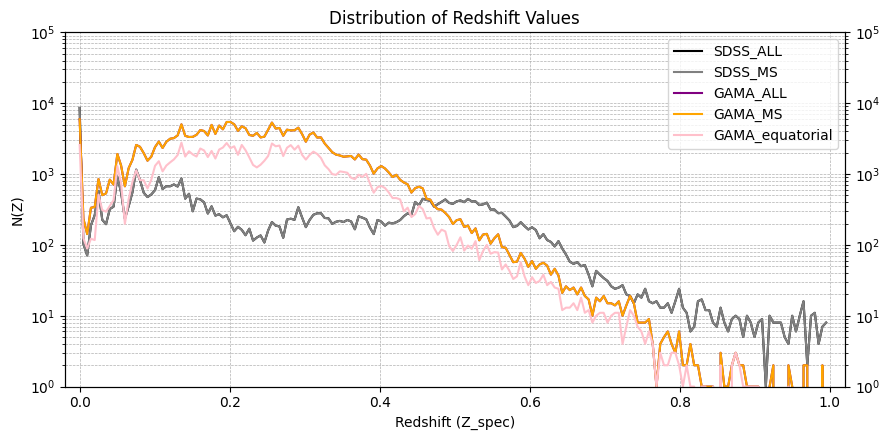

In [196]:
# Extract the redshift values (NQ>2)
Z_SDSS_ALL = SDSS_ALL['Z']
Z_SDSS_MS = SDSS_MS['Z']
Z_GAMA_ALL = GAMA_ALL['Z']
Z_GAMA_MS = GAMA_MS['Z']
Z_GAMA_equatorial = GAMA_equatorial['Z']

bins = np.linspace(0,1, 200)

# Calculate histograms
hist_SDSS_ALL, edges_SDSS_ALL = np.histogram(Z_SDSS_ALL, bins=bins, range=(0, 1))
hist_SDSS_MS, edges_SDSS_MS = np.histogram(Z_SDSS_MS, bins=bins, range=(0, 1))
hist_GAMA_ALL, edges_GAMA_ALL = np.histogram(Z_GAMA_ALL, bins=bins, range=(0, 1))
hist_GAMA_MS, edges_GAMA_MS = np.histogram(Z_GAMA_MS, bins=bins, range=(0, 1))
hist_GAMA_equatorial, edges_GAMA_equatorial = np.histogram(Z_GAMA_equatorial, bins=bins, range=(0, 1))


# Plot histograms as lines
fig, ax = plt.subplots(figsize=(9, 4.5))

ax.plot(edges_SDSS_ALL[:-1], hist_SDSS_ALL, color='black', label='SDSS_ALL')
ax.plot(edges_SDSS_MS[:-1], hist_SDSS_MS, color='gray', label='SDSS_MS')
ax.plot(edges_GAMA_ALL[:-1], hist_GAMA_ALL, color='purple', label='GAMA_ALL')
ax.plot(edges_GAMA_MS[:-1], hist_GAMA_MS, color='orange', label='GAMA_MS')
ax.plot(edges_GAMA_equatorial[:-1], hist_GAMA_equatorial, color='pink', label='GAMA_equatorial')

ax.set_xlabel('Redshift (Z_spec)')
ax.set_ylabel('N(Z)')
ax.set_title('Distribution of Redshift Values')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(1, 10**5)

# Create a twin y-axis
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()

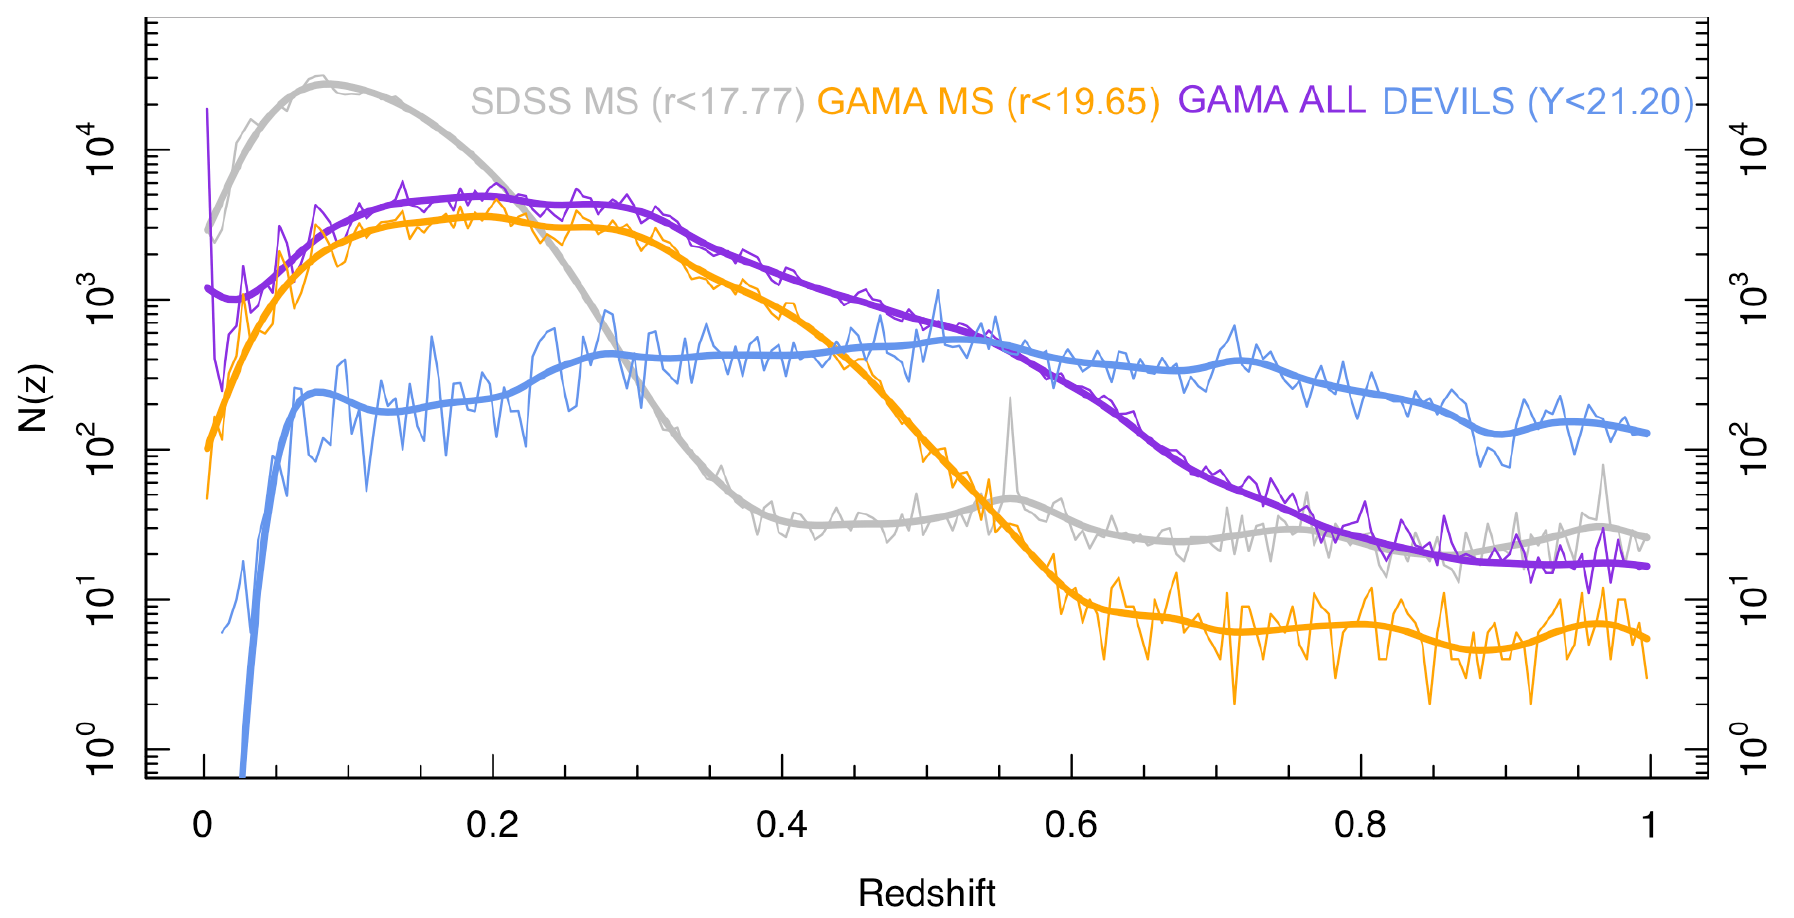

In [197]:
image_path = '/home/farnoosh/Pictures/Screenshot_20231024_221118.png'
Image(filename=image_path)


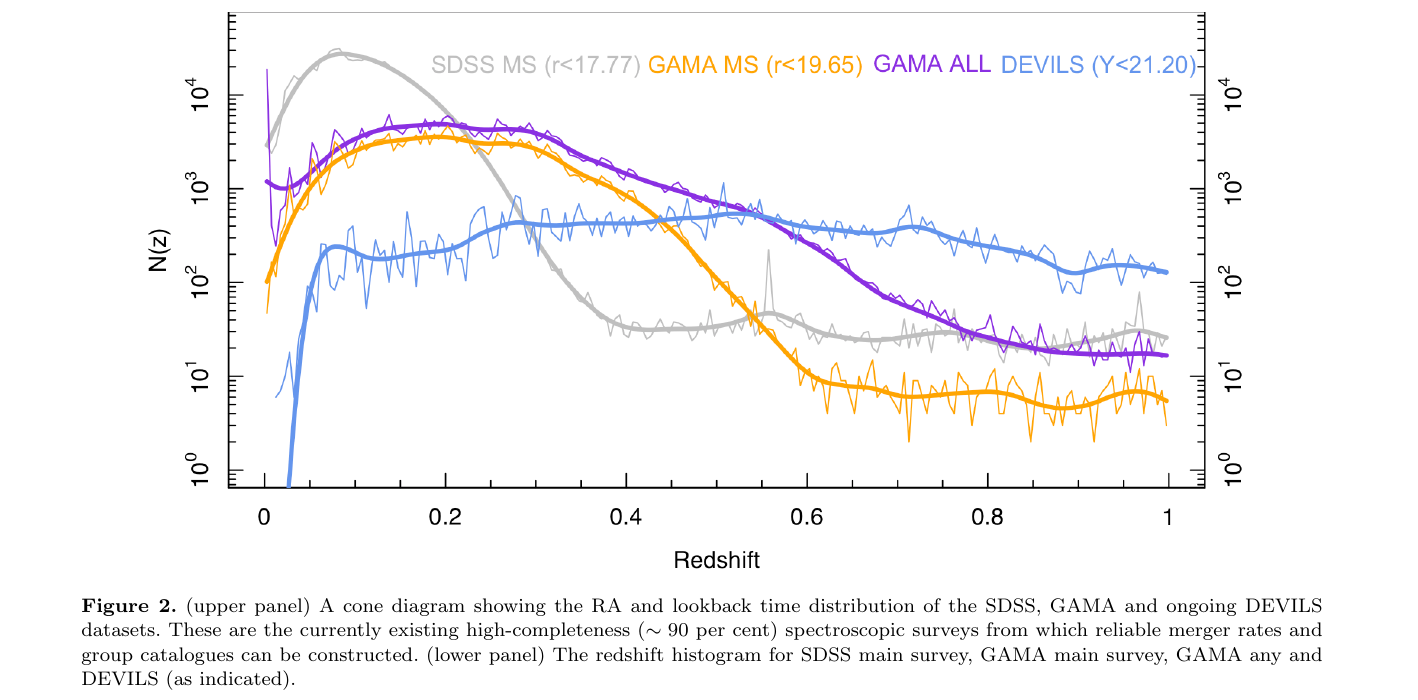

In [198]:
# as it seen the plot is not exactly the same as Driver. SDSS should be highest between 0 to 0.2
# and become lowest from 0.35 to 5.5 that is right that GAMA_ALL is higher than GAMA_MS all the time,
# but GAMA_MS (orange) after 0.3-0.4 reduce a lot, more than GAMA_ALL (purple)

In [199]:
# Constants and units
H0 = 70.0 * u.km / u.s / u.Mpc  # Hubble constant
Om0 = 0.30  # Matter density parameter
Ode0 = 0.70  # Dark energy density parameter
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)  # Cosmology model
c = c_const.to(u.km / u.s)  # Corrected this line
print(H0)

70.0 km / (Mpc s)


TypeError: unhashable type: 'numpy.ndarray'

In [201]:
# Cone plot
# Calculate distances for all objects in the entire SpecObjv27 dataset
Z_SpecObjv27 = SpecObjv27_raw['Z']
dist_SpecObjv27 = (c_const * Z_SpecObjv27 / cosmo.H0).to(u.Mpc)

# Create subsets based on these distances
SDSS_ALL = SpecObjv27_raw[SDSS_mask]
SDSS_MS = SDSS_ALL[MS_mask]
GAMA_ALL = SpecObjv27_raw[GAMA_mask]
GAMA_MS = GAMA_ALL[MS_mask]

# Create an equatorial mask of the same length as GAMA_mask
equatorial_mask = equatorial_mask = (
        region_masks_SpecObj['G09'] |
        region_masks_SpecObj['G12'] |
        region_masks_SpecObj['G15']
)
equatorial_mask = equatorial_mask[:len(GAMA_mask)]  # Make the mask the same length as GAMA_mask

GAMA_equatorial = GAMA_ALL[equatorial_mask]

# Print Z of all the objects in the whole dataset of SpecObjv27
print("Z of all the objects in the whole data set of SpecObjv27:")
print(Z_SpecObjv27)

# Print the distances of all objects in SpecObjv27
print("Distances of all objects in SpecObjv27:")
print(dist_SpecObjv27)

# Now you have your subsets based on redshift and distances:
Z_datasets = {
    'SDSS_ALL': {'Z': SDSS_ALL['Z'], 'Distances': dist_SpecObjv27[SDSS_mask]},
    'SDSS_MS': {'Z': SDSS_MS['Z'], 'Distances': dist_SpecObjv27[SDSS_mask & MS_mask]},
    'GAMA_ALL': {'Z': GAMA_ALL['Z'], 'Distances': dist_SpecObjv27[GAMA_mask]},
    'GAMA_MS': {'Z': GAMA_MS['Z'], 'Distances': dist_SpecObjv27[GAMA_mask & MS_mask]},
    'GAMA_equatorial': {'Z': GAMA_equatorial['Z'], 'Distances': dist_SpecObjv27[equatorial_mask]}
}

# Print the distances and Z for different subsets
for dataset in Z_datasets:
    z_values = Z_datasets[dataset]['Z']
    distances = Z_datasets[dataset]['Distances']

    z_max = z_values.max()
    z_min = z_values.min()
    dist_max = distances.max()
    dist_min = distances.min()

    print(f'3. Z of {dataset}:')
    print(z_values)
    print(f'{dataset} - Max Z: {z_max}, Min Z: {z_min}')

    print(f'4. Distances for {dataset}:')
    print(distances)
    print(f'{dataset} - Max Distance: {dist_max}, Min Distance: {dist_min}')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 57625 but corresponding boolean dimension is 344905

the lookback time t(z) at a given redshift z, where H0 is the Hubble constant, Ωm is the matter density parameter, and ΩΛ is the dark energy density parameter. The integral is evaluated from 0 to z.
since H0 is in (km/s.Mpc) and the Omegas are dimetionless, so the time t(z) is in Gyr

<font size="5">

$$ t(z) = \frac{1}{H_0} \int_0^z \frac{(1+z')}{\sqrt{\Omega_m (1+z')^3 + \Omega_\Lambda}} \, dz' $$


In [14]:

# Function to calculate the integrand of the lookback time formula
def integrand(zp, Om0, Ode0):
    return (1 + zp) / np.sqrt(Om0 * (1 + zp)**3 + Ode0)

# Function to calculate lookback time for a given redshift
def lookback_time(z, H0, Om0, Ode0):
    integral, _ = quad(integrand, 0, z, args=(Om0, Ode0))
    return (1 / H0) * integral * u.Gyr  # Return the lookback time in Gyr

# Calculate lookback times for each dataset
lookback_times_datasets = {}
for name, redshifts in Z_datasets.items():
    lookback_times = np.array([lookback_time(z, H0, Om0, Ode0).value for z in redshifts]) * u.Gyr
    lookback_times_datasets[name] = lookback_times

    print(f"lookback times for {name}: {lookback_times[:30]}")

lookback times for SDSS_MS: [6.30430950e-03 5.19087725e-05 1.05899438e-03 1.42520856e-03
 1.56846591e-03 1.42655592e-03 1.46475415e-03 1.55734531e-03
 1.54172194e-03 1.97735874e-03 4.75667487e-03 1.12171169e-03
 5.93662533e-03 5.43455072e-03 5.42215955e-03 6.62135846e-03
 1.08655764e-03 2.36464399e-03 1.58755899e-03 1.07425505e-03
 1.98951188e-03 4.74134612e-03 4.72155046e-03 4.70000486e-03
 4.78750115e-03 1.63149529e-03 4.75763289e-03 4.66666025e-03
 4.60877987e-03 1.09382267e-03] Gyr
lookback times for GAMA_MS: [7.31670343e-04 2.37936151e-03 3.28533764e-03 5.08405388e-03
 5.06561895e-03 5.95991546e-03 3.45017481e-03 3.44281420e-03
 4.98647446e-03 5.00681427e-03 6.95559646e-03 7.55139599e-03
 4.75683477e-03 1.11325355e-03 4.75699421e-03 4.14466516e-03
 6.40281744e-03 5.46285974e-05 4.76194486e-03 4.77440234e-03
 4.14529903e-03 1.67623664e-03 4.99127856e-03 6.14300293e-03
 3.84160320e-03 4.78750115e-03 3.83372177e-03 2.93899586e-03
 1.08211033e-03 1.08581638e-03] Gyr
lookback times for

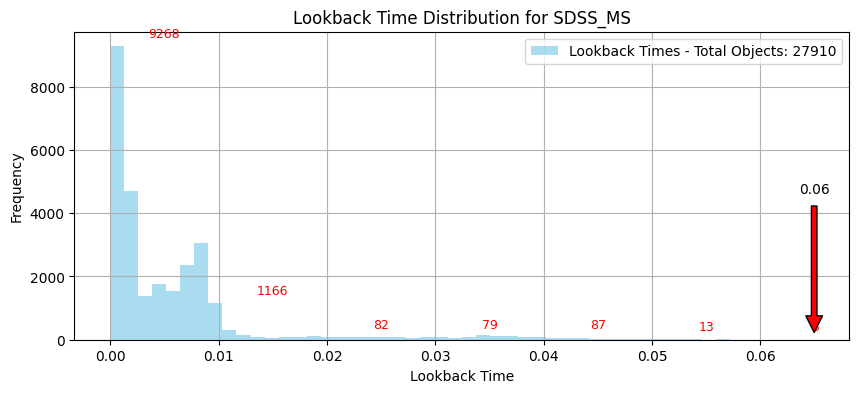

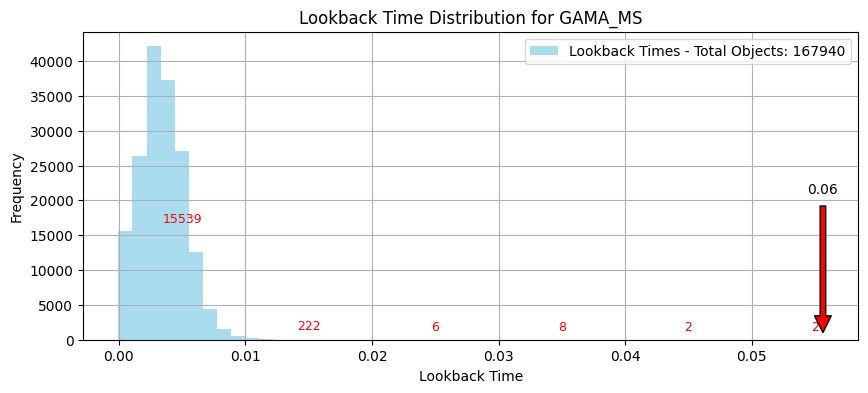

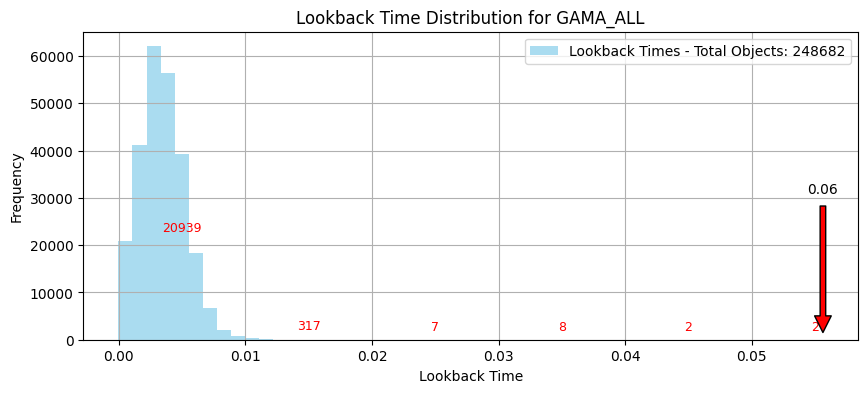

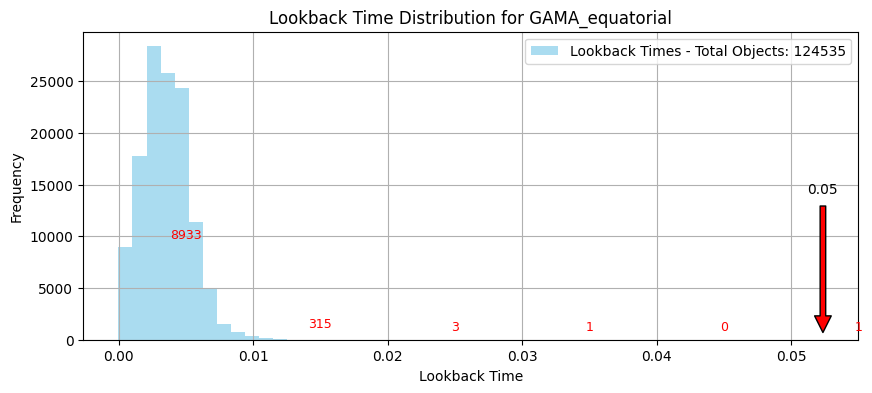

In [15]:
'''look at the numbers above! all the objects that their loockback time is calculated
are in range of 10^-3, and it is weird! so i decided to see the distribution
of loockback time values''' 


# Plot histograms of lookback times for each dataset
for name, lookback_times in lookback_times_datasets.items():
    plt.figure(figsize=(10, 4))
    total_count = len(lookback_times)  # Get the total count of objects
    counts, bins, patches = plt.hist(lookback_times.value, bins=50, color='skyblue', alpha=0.7, 
             label=f'Lookback Times - Total Objects: {total_count}')
    plt.title(f'Lookback Time Distribution for {name}')
    plt.xlabel('Lookback Time')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    # Calculate the bin width
    bin_width = bins[1] - bins[0]

    # Annotate the number of objects at the middle of each gridline on the x-axis
    ax = plt.gca()
    xticks = ax.get_xticks()
    for i in range(len(xticks) - 1):
        xtick = (xticks[i] + xticks[i + 1]) / 2  # Get the middle point between two gridlines
        bin_index = int((xticks[i] - bins[0]) // bin_width)
        if 0 <= bin_index < len(counts):
            count = counts[bin_index]
            plt.text(xtick, count + max(counts) * 0.02, str(int(count)), color='red', fontsize=9, ha='center', va='bottom')
   
    # Annotate the maximum lookback time on the plot
    max_lookback_time = max(lookback_times.value)
    plt.annotate(f'{max_lookback_time:.2f}', xy=(max_lookback_time, 0), xytext=(max_lookback_time, max(counts)/2), 
                 arrowprops=dict(facecolor='red', shrink=0.05), 
                 horizontalalignment='center')
    
    plt.show()
    
    


In [16]:
# # Printing sample redshift and corresponding lookback time values
# for name, redshifts in Z_datasets.items():
#     lookback_times = np.array([lookback_time(z, H0, Om0, Ode0).value for z in redshifts]) * u.Gyr
    
#     print(f"Sample redshift values for {name}      : {redshifts[:5]}")
#     print(f"Corresponding lookback times for {name}: {lookback_times[:5]}\n")


Min RA (degree): 30.04525
Max RA (degree): 351.89746
Min Lookback Time (Gyr): -5.9075319434211585e-05
Max Lookback Time (Gyr): 0.06495772570379169


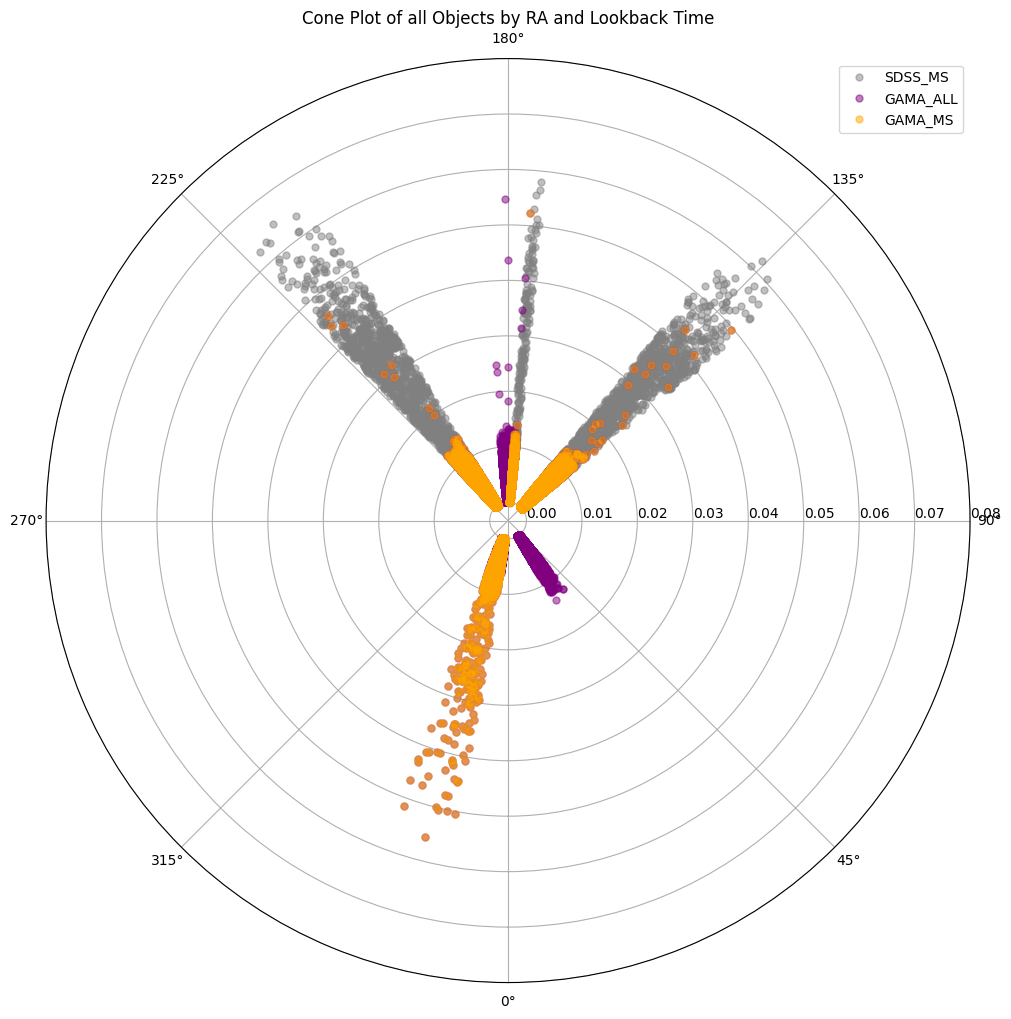

In [17]:
# figure 2 _ cone plot

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='polar')

datasets = {
    'SDSS_MS' : {'data': SDSS_MS,  'color': 'gray',   'lookback_times': lookback_times_datasets['SDSS_MS']},
    'GAMA_ALL': {'data': GAMA_ALL, 'color': 'purple', 'lookback_times': lookback_times_datasets['GAMA_ALL']},
    'GAMA_MS' : {'data': GAMA_MS,  'color': 'orange', 'lookback_times': lookback_times_datasets['GAMA_MS']},
    #'GAMA_equatorial': {'data': GAMA_equatorial, 'color': 'green', 'lookback_times': lookback_times_datasets['GAMA_equatorial']}
}


# Initialize lists to store all RA and lookback times
all_RA_deg = []
all_lookback_times_Gyr = []

for name, props in datasets.items():
    RA_deg = props['data']['RA']  # Original RA in degrees
    RA_rad = np.deg2rad(RA_deg)  # Convert RA to radians for the polar plot
    lookback_times_Gyr = props['lookback_times'].to(u.Gyr).value  # Lookback times in Gyr
    
    # Store RA and lookback times in the lists
    all_RA_deg.extend(RA_deg)
    all_lookback_times_Gyr.extend(lookback_times_Gyr)
    
    ax.plot(RA_rad, lookback_times_Gyr, 'o', color=props['color'], markersize=5, label=name, alpha=0.5)

# Convert lists to numpy arrays for easier handling
all_RA_deg = np.array(all_RA_deg)
all_lookback_times_Gyr = np.array(all_lookback_times_Gyr)

# Print min and max of RA and lookback times
print(f"Min RA (degree): {all_RA_deg.min()}")
print(f"Max RA (degree): {all_RA_deg.max()}")
print(f"Min Lookback Time (Gyr): {all_lookback_times_Gyr.min()}")
print(f"Max Lookback Time (Gyr): {all_lookback_times_Gyr.max()}")

ax.set_theta_zero_location("S")  # Set 0 degree of polar plot at the top
ax.set_rlabel_position(90)  # Position of the radial labels
ax.set_rmax(0.08)  # Set maximum radial limit to the age of the universe in Gyr

plt.title("Cone Plot of all Objects by RA and Lookback Time")
plt.legend()
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.integrate import quad
import pandas as pd
from astropy.cosmology import FlatLambdaCDM

# Assuming you already have SpecObjv27_raw loaded and filtered
SDSS = SpecObjv27_raw[SDSS_mask]

# Assuming you have already defined the lookback_time function as earlier
H0 = 70 * u.km / u.s / u.Mpc
Om0 = 0.3
Ode0 = 0.7

# Calculate lookback times for SDSS
SDSS_redshifts = SDSS['Z']
SDSS_lookback_times = np.array([lookback_time(z, H0, Om0, Ode0).value for z in SDSS_redshifts]) * u.Gyr

# Create the cone plot
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='polar')

# Convert RA to radians
RA_rad = np.deg2rad(SDSS['RA'])

ax.plot(RA_rad, SDSS_lookback_times, 'o', color='blue', markersize=5, alpha=0.5, label='SDSS')

ax.set_theta_zero_location("S")  # Set 0 degree of polar plot at the top
ax.set_rlabel_position(90)  # Position of the radial labels
ax.set_rmax(SDSS_lookback_times.max().value)  # Adjust the maximum radial limit

plt.title("Cone Plot of SDSS Objects by RA and Lookback Time")
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'pandas'